# Uncertainty Estimation

## Monte-Carlo droput 
See paper: [Dropout as a Bayesian Approximation](https://arxiv.org/pdf/1506.02142)

*'In this paper we develop a new theoretical framework casting dropout training in deep neural networks (NNs) as approximate Bayesian inference in deep Gaussian processes. A direct result of this theory gives us tools to model uncertainty with dropout NNs – extracting information from existing models that has been thrown away so far.'*

In other words:   
*Keeping dropout active during inference and running multiple forward passes—known as Monte Carlo sampling—approximates Bayesian inference.  
This approach provides uncertainty estimates for the model’s predictions and typically results in better calibration.*

In [1]:
# New functions for monte carlo dropout confidence computation.
from monte_carlo import mc_resample, summarize_prediction_confidence

## Global configs

In [2]:
from typing import Any, Tuple
import logging
from pathlib import Path
import h5py
import base64
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

PATH_TO_FACE_DATA = Path("/sc-scratch/sc-scratch-dh-face/face/face_telemedical_ecgs-2025-05-02")
SAMPLE_RATE = 128
GLOBAL_MODEL_RHYTHM = None

## Define wrappers for Getemed functios adding MC-Resampling predictions

In [37]:
dataset = InferenceDataset(ecg, PREDICTION_CONFIG)
loader = DataLoader(dataset)

In [ ]:
# Modified functions from GETEMED

from getemed_ml_library.datastructures.ecg import ECG
from ssl_model.helpers_train.dataset import a
from ssl_model.helpers_train.model_components import pad_and_mask_batch_tensor
from ssl_model.helpers_data.process_ecg import prepare_ecg, normalize_single_strip
from ssl_model.prediction import calc_rhythm_regions, load_model, get_regions_from_model_output
from ssl_model.helpers_train.device_config import get_maximum_workers
from ssl_model.helpers_train.dataloader import create_dataloader

from getemed_ml_library.base_logger import logger

# Turn off logging. We dont need it in this notebook.
logger.setLevel(0)

def calculate_predictions(
    inference_dataloader: DataLoader,
    device,
    max_samples_model: int,
    model,
    num_classes: int,
    mc_samples: int = 0
) -> (np.ndarray, np.ndarray, list[int]):
    """Calculate predictions for batched data.
    Args:
        inference_dataloader: Dataloader for InferenceDataset
        device: Device to use for calculation
        max_samples_model: Maximum number of samples the model can process
        model: Model to use for prediction
        num_classes: Number of classes the model can predict
        mc_samples: Number of resamples using monte carlo uncertainty estimation (https://arxiv.org/pdf/1506.02142). If 0, no resampling is used.
    Returns:
        Tuple of predictions (batch_size, num_classes),
         detailed predictions (batch_size, num_classes, n_samples)
         and number of empty samples (batch_size)
    """
    model.eval()
    confidence_all = []
    predictions_all = np.empty((0, num_classes))
    predictions_detailed_all = np.empty((0, num_classes, max_samples_model))
    n_empty_samples_all = np.empty((0))
    with torch.no_grad():
        for batch in inference_dataloader:
            # batch: (batch_size, n_samples, n_channels), n_empty_samples: (batch_size)
            padded_batch, n_empty_samples = pad_and_mask_batch_tensor(
                batch, max_samples_model
            )
            n_empty_samples = n_empty_samples.to(device)
            batch_tensor = padded_batch.to(device)

            confidence_info = {} 
            if mc_samples > 0:
                all_class_preds, all_detailed_preds = mc_resample(model, batch_tensor, n_empty_samples, mc_samples)
                confidence_info = summarize_prediction_confidence(all_class_preds.sigmoid())

                class_preds = all_class_preds.mean(dim=0)
                detailed_preds = all_detailed_preds.mean(dim=0)
            else:
                class_preds, detailed_preds = model(batch_tensor, n_empty_samples)

            confidence_all.append(confidence_info)
            
            # pylint: enable=not-callable
            # softmax output, move to cpu and stack
            predictions_all = np.vstack(
                (predictions_all, F.softmax(class_preds, dim=1).cpu().numpy())
            )
            predictions_detailed_all = np.vstack(
                (
                    predictions_detailed_all,
                    F.softmax(detailed_preds, dim=1).cpu().numpy(),
                )
            )
            n_empty_samples_all = np.concatenate(
                (n_empty_samples_all, n_empty_samples.cpu().numpy())
            )
    return predictions_all, predictions_detailed_all, list(n_empty_samples_all), confidence_all


def calc_rhythm_regions(
    ecg: ECG,
    model_rhythm,
    device,
    prediction_config: dict[str, Any],
    skip_preprocessing: bool = False,
) -> Tuple[list[dict], list[dict]]:
    """
    Detect different rhythms in an ECG and return the found rhythm regions.
    ECG is analyzed in slices of fixed size. If the ECG length isn't a multiple
    of the window size, the samples after the last slice will be annotated as "OTHER".
    :param ecg: ECG that will be analyzed
    :param model_rhythm: Model that will be used for the prediction
    :param device: Device to use for calculation
    :param prediction_config: Configuration for the prediction
    containing
    - mode_merge_preds: Mode to merge detailed predictions to overall predictions, could be
            "only-detailed", "only-overall" or "weighted".
    - model_sample_rate: Number of samples per second in the model output.
    - window_size_in_s: Number of seconds in a window.
    - stride_step_in_s: Number of seconds to move the window forward.
    - label_mapping: Mapping from index to rhythm
        e.g. {0: "SR", 1: "AFIB", 2: "OTHER", 3: "NOISE"}
    - min_range: Minimum range for each rhythm in samples (sample rate of model!)
        e.g. {"SR": 0, "AFIB": 0, "OTHER": 0, "NOISE": 0}
    - individual_softmax_thresholds: Thresholds for each rhythm in softmax
        e.g. {0: 0, 1: 0, 2: 0, 3: 0}
    - thresholds_removal: Optional Dict with following keys:
        - threshold_short_regions: Threshold for short duration ECGs
        - threshold_long_regions: Threshold for long duration ECGs
        - decay_rate: Decay rate for the threshold
    :param skip_preprocessing: If True, skip the preprocessing of the ECG
        (because it was already done)

    :returns: list of dictionaries of format, [start,end)
    {"start": <sample>, "end": <sample>, "rhythm": <rhythm>}
    """
    original_sample_rate = ecg.sample_rate
    original_n_samples = ecg.number_samples

    ecg = deepcopy(ecg)
    dataset = InferenceDataset(
        ecg=ecg,
        prediction_config=prediction_config,
        skip_preprocessing=skip_preprocessing,
    )
    n_workers = 64 
    
    dataloader = create_dataloader(
        dataset, prediction_config["batch_size"], n_workers, shuffle=False
    )

    preds_all, preds_detailed_all, _, confidence = calculate_predictions(
        dataloader,
        device,
        prediction_config["max_samples_model"],
        model_rhythm,
        num_classes=len(prediction_config["label_mapping"]),
        mc_samples=prediction_config.get("mc_samples", 0)
    )

    list_of_regions_predicted, list_of_predictions = get_regions_from_model_output(
        preds_all,
        preds_detailed_all,
        original_sample_rate,
        original_n_samples,
        prediction_config,
    )

    thresholds_removal = prediction_config.get("thresholds_removal", None)

    return list_of_regions_predicted, list_of_predictions, confidence

## Model & Data loading

In [ ]:
def load_rhythm_model(device):
    """Load rhythm model from file."""
    logger.info("Loading rhythm model...")
    return load_model(device)

def ensure_rhythm_model_loaded():
    """Loads the global rhythm model on CUDA if available, otherwise on CPU.
    If model is not loaded, it will be loaded and stored in a global variable.

    Returns the model and the device used.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info("Using device: %s", device)

    # pylint: disable=global-statement
    global GLOBAL_MODEL_RHYTHM
    # pylint: enable=global-statement

    if GLOBAL_MODEL_RHYTHM is None:
        model_rhythm = load_rhythm_model(device)
        GLOBAL_MODEL_RHYTHM = model_rhythm
    else:
        model_rhythm = GLOBAL_MODEL_RHYTHM

    return model_rhythm, device

def load_one_strip_from_binary_hdf5_file(
    path: Path, filename: str, strip_index: int, n_channels: int = 2
) -> np.ndarray:
    with h5py.File(str(Path(path, filename)), "r") as file:
        encoded_strip = file["ecg_strips"][strip_index]
        binary_data = base64.b64decode(encoded_strip)
        np_array = (
            np.frombuffer(binary_data, dtype=np.float32).reshape(-1, n_channels).copy()
        )

    return np_array


def impute_positions(pos, label, total_length):
    """
    Impute positions with a new rhythm label for all gaps in the ECG trace.

    Args:
        pos (list of dict): List of dicts with 'start', 'end', and 'rhythm' keys.
        label (str): The rhythm label to impute in uncovered regions.
        total_length (int): Total length of the ECG signal.

    Returns:
        list of dict: Complete list of non-overlapping rhythm segments covering the full signal.
    """

    # Sort positions by start index
    pos = sorted(pos, key=lambda x: x['start'])
    output = []
    current = 0

    for segment in pos:
        if current < segment['start']:
            # Add missing segment before this one
            output.append({'start': current, 'end': segment['start'], 'rhythm': label})
        # Add the original segment
        output.append(segment)
        current = segment['end']

    # Add remaining segment after the last one, if any
    if current < total_length:
        output.append({'start': current, 'end': total_length, 'rhythm': label})

    return output

class ReannotationData:
    def __init__(self, df, ecg_only=True, process_ecg=False):
        self.df = df.copy()
        self.process_ecg = process_ecg
        self.ecg_only = ecg_only

        # Maps all unique ecg_indeces to a continues ReannotationData index later used in __getitem__. 
        self.index_to_ecgid = {idx: int(_id) for idx, _id in enumerate(self.df.ecg_index.unique())}

    def _generate_regions(self, ecg_id, ecg_length):
        regions = self.df.loc[(self.df.ecg_index == ecg_id) & (self.df.final_annotation == True), "diagnostic_type"].item()
        noise = dataset.df.loc[(dataset.df.ecg_index == 8) & (dataset.df.entry_type == "regions"), "final_annotation"].item()
        return impute_positions(noise, regions, ecg_length)
    
    def __len__(self):
        return len(self.index_to_ecgid) - 1

    def __getitem__(self, idx) -> Tuple[ECG, dict]:

        _id = self.index_to_ecgid[idx]

        ecg_sample = self.df.loc[(self.df.ecg_index == _id) & (self.df.entry_type == "regions"), :]

        if len(ecg_sample) == 1:        
            ecg_sample = ecg_sample.iloc[0]
        else:
            raise ValueError(f"Expected unique ECG. Found {len(ecg_sample)}!")

        ecg_data = load_one_strip_from_binary_hdf5_file(PATH_TO_FACE_DATA, "ecg_strips.hdf5", strip_index=_id, n_channels=2)
        ecg = ECG(id=_id, patient_id=ecg_sample.patient_id, samples=ecg_data, sample_rate=SAMPLE_RATE)

       
        if self.process_ecg:
            ecg = prepare_ecg(ecg, SAMPLE_RATE)
            ecg = normalize_single_strip(ecg.samples)

        if self.ecg_only:
            return ecg

        regions = self._generate_regions(_id, len(ecg.samples) * 2) # Times 2 because of different sampling rates in annotation?! Needs clarification.

        return ecg, regions

In [30]:
test_df = pd.read_pickle(PATH_TO_FACE_DATA / "reannotation_df.pkl")
test_df = test_df[test_df.splitset == "test"].reset_index().copy()

dataset = ReannotationData(test_df)

## Run monte carlo inference with confidence summary

In [ ]:
# Censored internal configuration for rhythm model prediction.
PREDICTION_CONFIG = {  }

In [55]:
# Load model and a test sample
model_rhythm, device = ensure_rhythm_model_loaded()
ecg = dataset[0]

In [56]:
# Run prediction with MC droout confidence computation
PREDICTION_CONFIG["mc_samples"] = 100
mc_regions, mc_predictions, confidence = calc_rhythm_regions(ecg, model_rhythm, device, PREDICTION_CONFIG)

In [57]:
print("Confidence summary:")
confidence

Confidence summary:


[{'confidence': tensor([0.1456]),
  'entropy': tensor([[0.9492, 0.5429, 0.9948, 0.9306]]),
  'mc_samples': 100,
  'mean': tensor([0.5226]),
  'label_mean': tensor([[0.3849, 0.8728, 0.4801, 0.3527]]),
  'std': tensor([0.2128]),
  'label_std': tensor([[0.0634, 0.0331, 0.0376, 0.0433]]),
  'var': tensor([0.0453]),
  'label_var': tensor([[0.0040, 0.0011, 0.0014, 0.0019]])}]

In [58]:
# Run basic prediction without MC
PREDICTION_CONFIG["mc_samples"] = 0
pred_regions, predictions, _ = calc_rhythm_regions(ecg, model_rhythm, device, PREDICTION_CONFIG)

## Visualize GT and predictions

In [11]:
%matplotlib inline

def plot_ecgs(ecg_data, pred=None, channel_last=True, title=""):
    if channel_last:
        ecg_data = np.moveaxis(ecg_data, -1, 0)
    
    n_channels = ecg_data.shape[0]

    fig, axs = plt.subplots(nrows=n_channels, ncols=1, figsize=(9, n_channels), sharex=True)
    fig.suptitle(title)
    
    rhythm_colors = {
        'afib': 'lightcoral',
        'noise': 'lightgray',
        'other': 'lightred',
        'sr': 'lightgreen'
    }
    
    for ax, e in zip(axs, ecg_data):
        ax.plot(e)
        
        # Highlight prediction regions if provided
        if pred is not None:
            for p in pred:
                start = p['start'] / 2 # !!! Labels have 256 samplng rate. Adjust to 128
                end = p['end'] / 2 # !!! Labels have 256 samplng rate. Adjust to 128
                rhythm = p['rhythm'].lower()
                
                # Get color for this rhythm, default to lightblue if not specified
                color = rhythm_colors.get(rhythm, 'lightblue')
                
                ax.axvspan(start, end, facecolor=color, alpha=0.3)
                
                # Optionally add rhythm label in the middle of the region
                mid_point = (start + end) / 2
                ax.text(mid_point, ax.get_ylim()[1] * 0.9, rhythm.upper(), 
                       ha='center', va='top', fontsize=8)

    plt.tight_layout()
    plt.show()

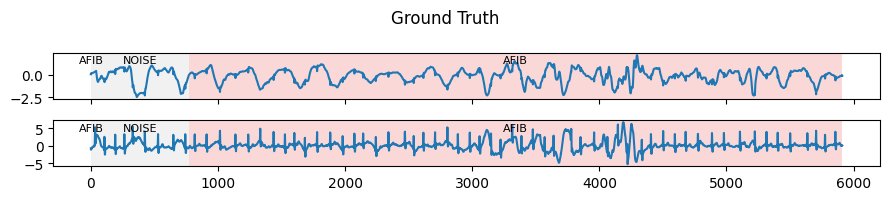

In [12]:
plot_ecgs(ecg.samples, pred=label, title="Ground Truth")

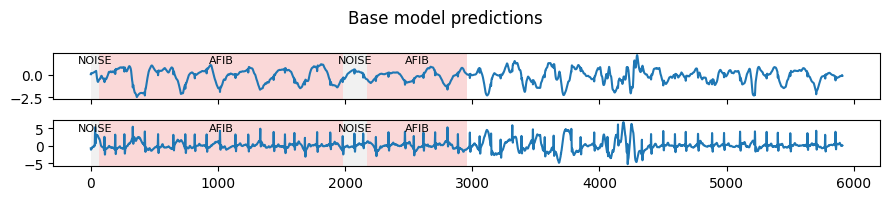

In [13]:
plot_ecgs(ecg.samples, pred=pred_regions, title="Base model predictions")

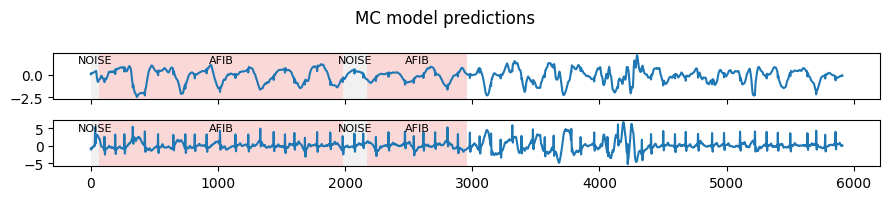

In [14]:
plot_ecgs(ecg.samples, pred=mc_regions, title="MC model predictions")

## Generate all confidence summary

Generate a summary to analysie distribution of prediction and confidence

In [168]:
from tqdm import tqdm
from collections import defaultdict
import pickle

In [75]:
class InferenceDataForBatching:
    """Dataset allows loading batches of ECGs. Assumption: No windowing required, aka len(ecg) < max_samples_model"""
    def __init__(self, df, prediction_config):
        self.df = df.copy()
        self.prediction_config = prediction_config

        # Maps all unique ecg_indeces to a continues ReannotationData index later used in __getitem__. 
        self.index_to_ecgid = {idx: int(_id) for idx, _id in enumerate(self.df.ecg_index.unique())}
    
    def __len__(self):
        return len(self.index_to_ecgid)

    def __getitem__(self, idx) -> Tuple[ECG, dict]:

        _id = self.index_to_ecgid[idx]

        ecg_sample = self.df.loc[(self.df.ecg_index == _id) & (self.df.entry_type == "regions"), :]

        if len(ecg_sample) == 1:        
            ecg_sample = ecg_sample.iloc[0]
        else:
            raise ValueError(f"Expected unique ECG. Found {len(ecg_sample)}!")

        ecg_data = load_one_strip_from_binary_hdf5_file(PATH_TO_FACE_DATA, "ecg_strips.hdf5", strip_index=_id, n_channels=2)
        ecg = ECG(id=_id, patient_id=ecg_sample.patient_id, samples=ecg_data, sample_rate=SAMPLE_RATE)

        ecg = prepare_ecg(ecg, SAMPLE_RATE)
        ecg = normalize_single_strip(ecg.samples)
        ecg = torch.from_numpy(ecg).float().unsqueeze(0)
        ecg, n_empty = pad_and_mask_batch_tensor(ecg, self.prediction_config["max_samples_model"])

        return ecg[0], n_empty


In [96]:
dataset = InferenceDataForBatching(test_df, PREDICTION_CONFIG)
loader = DataLoader(dataset, batch_size=32, num_workers=8)

In [165]:
model_rhythm, device = ensure_rhythm_model_loaded()

complete_summary = defaultdict(list)

with torch.no_grad():
    for ecg, n_empty_samples in tqdm(loader):
        ecg, n_empty_samples = ecg.to("cuda"), n_empty_samples.to("cuda")
        all_class_preds, all_detailed_preds = mc_resample(model_rhythm, ecg, n_empty_samples, num_samples=1000)
        confidence_info = summarize_prediction_confidence(all_class_preds.sigmoid())

        complete_summary["all_class_preds"].append(torch.moveaxis(all_class_preds.detach().cpu(), 0, 1))
        complete_summary["all_detailed_preds"].append(torch.moveaxis(all_detailed_preds.detach().cpu(), 0, 1))

        for k, v in confidence_info.items():
            if not isinstance(v, torch.Tensor):
                 complete_summary[k].append(torch.tensor([v]))   
            else:
                complete_summary[k].append(v)

for k, v in complete_summary.items():
    complete_summary[k] = torch.concatenate(v)

complete_summary = dict(complete_summary)

100%|██████████| 15/15 [02:44<00:00, 10.99s/it]


In [166]:
for k, v in complete_summary.items():
    print(k, v.shape)

all_class_preds torch.Size([452, 1000, 4])
all_detailed_preds torch.Size([452, 1000, 4, 7680])
confidence torch.Size([452])
entropy torch.Size([452, 4])
mc_samples torch.Size([15])
mean torch.Size([452])
label_mean torch.Size([452, 4])
std torch.Size([452])
label_std torch.Size([452, 4])
var torch.Size([452])
label_var torch.Size([452, 4])
